# Nonlinear System Identification
## Parameter Estimation of a nonlinear dynamical system with a model predictive objective optimization

by Markus Ullenbruch.

In this notebook, we want to estimate unknown system parameters of a dynamical system with the minimization of an objective.
To do this, we need
- mathematical model of the dynamical system
- measurement data of some or all states

This approach can be done with both linear and nonlinear dynamical system models.
The method is shown with a simple example of a nonlinear system: a physical pendulum with velocity proportional friction and coulomb friction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize
import pandas as pd

### Get measurement data
We simulate our measurement data with a simple nonlinear model with gaussian noise added to the measurements.
The system is representing a pendulum with nonlinear coulomb friction and velocity proportional friction.

In [2]:
# the system parameters to estimate later
p1 = 0.07 
p2 = 2.5
p3 = 0.2

def system_dynamics(t, x, p1, p2, p3):
    '''Dynamic model representing our system'''
    dx1 = x[1]
    dx2 = -p1*x[1] - p2*np.sin(x[0]) - p3*np.sign(x[1])
    return dx1, dx2

In [3]:
t_mess = np.arange(0, 20, 0.01)  # discrete measurement time points
x0 = [np.deg2rad(145), 0]  # Initial state phi0=145°, dphi0=0 rad/s

sol = solve_ivp(system_dynamics, (0, 20), x0, t_eval=t_mess, args=(p1, p2, p3))

x1_mess = sol.y[0,:] + np.random.normal(0, 0.07, size=sol.y.shape[1])  # adding guassian noise
x2_mess = sol.y[1,:] + np.random.normal(0, 0.07, size=sol.y.shape[1])

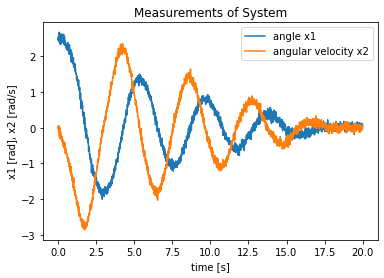

In [4]:
# plot measurements
plt.plot(t_mess, x1_mess, label='angle x1')
plt.plot(t_mess, x2_mess, label='angular velocity x2')
plt.title('Measurements of System')
plt.xlabel('time [s]')
plt.ylabel('x1 [rad], x2 [rad/s]')
plt.legend()
plt.show()

### Mathematical model and simulation of the dynamics
First we implement the function that defines the mathematical model dynamics of the underlying system the measuremts are taken from as a nonlinear first order system. Then we write a function that numerically simulates the model in the measurement's time horizon with the unknown system parameter as input.

Discontinuities like the signum function in the right hand side of the mathematical model are not handled well by the optimization solver scipy.minimize. Because of that, we approximate the Coulomb Friction $F_c = -p_3 \, \text{sign}(\dot{\phi})$ with a tangenshyperbolicus (tanh) function to make it continuous. So we approximate coulomb friction as $F_c \approx -p_3 \, \text{tanh}(c\,\dot{\phi})$ with c as a form parameter. The higher the form parameter $c$, the better the approximation of the signum function.

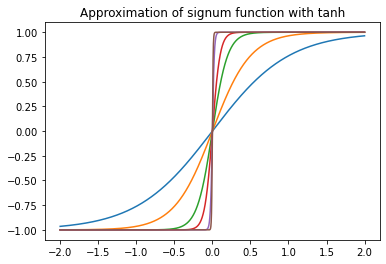

In [5]:
# Several approximations of coulomb friction with different form parameters c
t_approx = np.arange(-2, 2, 0.001)
for i in [1, 2, 5, 10, 40, 100]:
    y = np.tanh(i*t_approx)
    plt.plot(t_approx, y)
    plt.title('Approximation of signum function with tanh')

In [6]:
def Modell(x, t, p1, p2, p3):
    '''Mathematical model of the dynamic system
    
    p1, p2, p3 -- unknown system parameters to estimate
    '''
    dx1 = x[1]
    dx2 = -p1 * x[1] - p2 * np.sin(x[0]) - p3*np.tanh(200*x[1])
    return [dx1, dx2]


def simulate(p, t):
    '''Numerical simulation of the model
    
    p -- tuple of model parameter to estimate
    t -- simulation time equals discrete measurement time points
    return -- simulated system states/ trajectory
    '''
    X = np.zeros((len(t), 2))
    X[0,0] = x1_mess[0]
    X[0,1] = x2_mess[0]
    x0 = X[0]
    p1, p2, p3 = p
    for i in range(len(t)-1):
        tspan = [t[i], t[i+1]]
        y = odeint(Modell, x0, tspan, args=(p1, p2, p3) )
        x0 = y[-1]
        X[i+1] = x0
    return X

### Define objective
An objective is defined that will be minimized with regard to the unknown system parameters p.
The objective is the sum of the squared differences between simulated trajectory and measurement trajectory.
Alternatively the mean of the squared differences can be the objective.
The goal of the optimization process with the objective is the simulated trajectory with optimized parameters p to come as close to the measured trajectory as possible.

In [7]:
def objective(p):
    ''' Objetive function
    
    p -- (p1, p2, p3) tuple of system parameter to estimate
    return -- scalar objective value to minimize with regard to p
    '''
    Xp = simulate(p, t_mess)  # simulate dynamic of the system
    obj = np.sum((Xp[:,0] - x1_mess)**2) + np.sum((Xp[:,1] - x2_mess)**2)   # calculate objective which will get minimized
    return obj

### Optimization of the objective with scipy's minimize class

In [8]:
# Initial guess of the unknown system parameter
p10 = 0.18  # real 0.07
p20 = 3.5   # real 2.5
p30 = 0.4   # real 0.2
p0 = [p10, p20, p30]

# bounds in within the unknown system parameter are searched based on system knowledge
bnds = ((0.005, 0.2), (1.0, 5), (0.05, 0.5))
#bnds = None  # if we have no system knowledge

# Minimization process
solution = minimize(objective, p0, method='SLSQP', bounds=bnds)
print('Optimization Information:', '\n', solution)
p = solution.x

# show final objective
print('\nInitial SSE Objective: ' + str(objective(p0)))
print('Final SSE Objective: ' + str(objective(p)))

# optimized parameter values

print('found p1: ', p[0])
print('found p2: ', p[1])
print('found p3: ', p[2])

Optimization Information: 
      fun: 21.01091908547536
     jac: array([-0.0428679 , -0.00415301, -0.02105093])
 message: 'Optimization terminated successfully'
    nfev: 73
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0.06409827, 2.49240192, 0.20775059])

Initial SSE Objective: 2851.5625789894584
Final SSE Objective: 21.01091908547536
found p1:  0.06409826626916106
found p2:  2.492401921482369
found p3:  0.20775058546941427


In [9]:
Xi  = simulate(p0, t_mess)  # simulation with initial guess of parameters
Xp  = simulate(p, t_mess)   # simulation with optimized parameters

### Plot measurements and simulation of  the system with optimized parameters

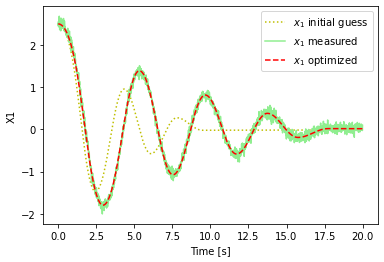

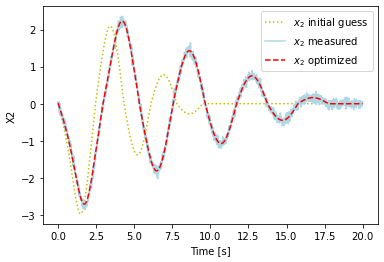

In [10]:
plt.figure(1)
plt.plot(t_mess, Xi[:,0],'y:',label=r'$x_1$ initial guess')
plt.plot(t_mess ,x1_mess,'b-',color='lightgreen', label=r'$x_1$ measured')
plt.plot(t_mess, Xp[:,0],'r--',label=r'$x_1$ optimized')
plt.ylabel('X1')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.plot(t_mess, Xi[:,1],'y:',label=r'$x_2$ initial guess')
plt.plot(t_mess, x2_mess,'b-',color='lightblue', label=r'$x_2$ measured')
plt.plot(t_mess, Xp[:,1],'r--',label=r'$x_2$ optimized')
plt.ylabel('X2')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.show()

### Summary
With this notebook you know the process of System Identification and estimating unknown system parameters with optimizing an objective with the scipy's minimize function.

You can adapt the method with any linear or nonlinear dynamical system if you have derived a mathematical model and measurement data of the system.

With the dynamical model in this notebook, we would be able to estimate the unknown parameters of a physical pendulum: The friction coefficient, the coulomb friction coefficient and the moment of inertia when we have measurement of the angle and the angular velocity.